Escala_PG4
BJBP
aural
Jocelyn Flores
EDEN-Gravity
Joji-SDITD
BJBG
Moonlight
Escala Cromática
Joji-Run
Orchestral Piece
BJBC
Jeremy Zucker-TIO
Unravel-TG
fur_elise
pr1VariasNotes
El_Eme
Jos9915-Pleni--Facultad_organica_1626.musicxml
VariasPiezas
NyanCat
My-
Tokyo
A Cruel Angel Thesis
BJB
TB
Horri
data
EDEN-Crash
Buu
Jos9915-Pleni--Facultad_organica_1626
Escriba el nombre del archivo:
Buu
Convirtiendo...
¿Quiere reproducirlo? Si(1) No(0)no
Ok
Listo.


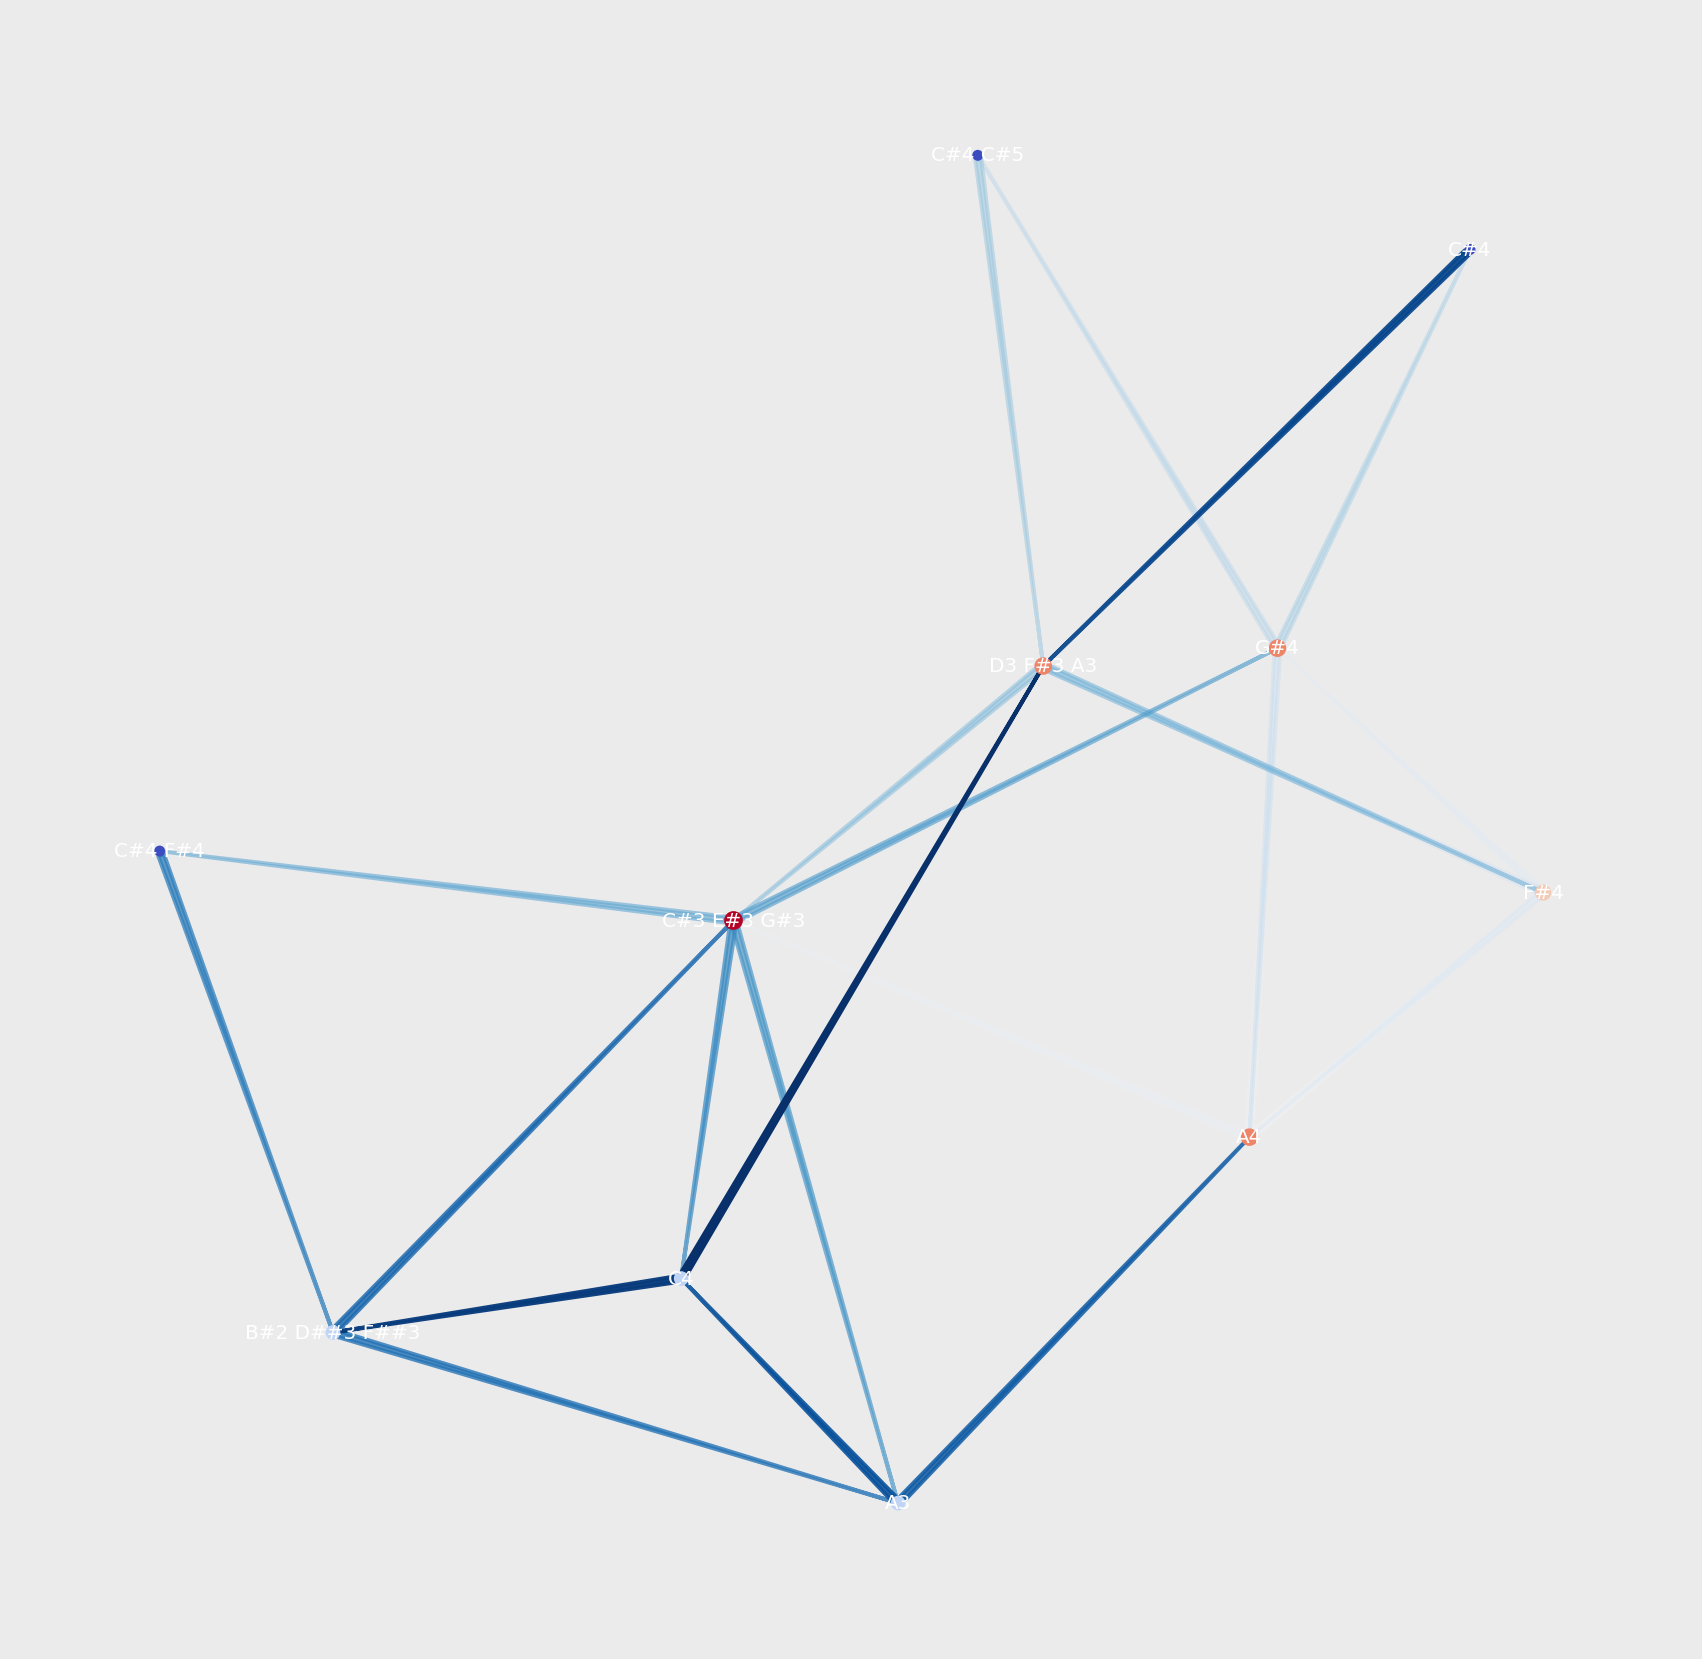

Pasando grafo a formato tridimensional...
Listo.


In [170]:
import igraph as ig
import netgraph, numpy, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import music21 as m
from os import listdir
from os.path import isfile, join
import chart_studio.plotly as py
import plotly.graph_objs as go

def c_2D():
    aDir = os.getcwd()

    onlyfiles = [f for f in listdir('{0}/ArchiXml/'.format(aDir)) if isfile(join('{0}/ArchiXml/'.format(aDir), f))]
    for i in onlyfiles:
        print(i.replace('.xml',''))

    nombre = input("Escriba el nombre del archivo:\n")
    song = m.converter.parse('{0}/ArchiXml/{1}.xml'.format(aDir, nombre))
    print("Convirtiendo...")
    repro = input('¿Quiere reproducirlo? Si(1) No(0)')
    if(repro == 1 or repro == '1' or repro == 'si' or repro == 'Si'):
        sp = m.midi.realtime.StreamPlayer(song)
        sp.play()
    else:
        print("Ok")

    song = song.stripTies()

    # unfold repetitions
    i = 0
    for a in song:
        if a.isStream:
            e = m.repeat.Expander(a)
            s2 = e.process()
            timing = s2.secondsMap
            song[i] = s2
        i += 1

    # todo: add note onsets


    def getMusicProperties(x):
        s = ''
        t = ''
        r = ''
        s = str(x.pitch)

        if x.tie != None:
            t = 't'
        elif(x.isRest):
            r = x.duration+'r'
        s += t+r
        s=s.replace('-','b')
        return s


    notas = []
    for a in song.recurse().notes:

        if (a.isNote):
            x = a
            s = getMusicProperties(x)
            notas.append(s)

        if (a.isChord):
            n = ''
            for x in a._notes:
                s = getMusicProperties(x)
                n += ' '+s
            notas.append(n[1:])

        if (a.isRest):
            print("hola")
            x = a
            s = getMusicProperties(x)
            notas.append(s)

    n = notas
    G = nx.DiGraph()
    for i in range(len(n)):
        if i != 0:
            G.add_edge(n[i-1], n[i])

    pos = nx.layout.kamada_kawai_layout(G)

    d = dict(G.degree)
    low, *_, high = sorted(d.values())
    norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
    node_sizes = [v*10 for v in d.values()]
    M = G.number_of_edges()
    edge_colors = range(2, M+2)
    edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
    fig = plt.figure()
    nodes = nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_sizes,
        node_color=[mapper.to_rgba(i) for i in d.values()]
    )
    edges = nx.draw_networkx_edges(
        G,
        pos,
        node_size=node_sizes,
        arrowstyle="wedge",
        arrowsize=10,
        edge_color=edge_colors,
        edge_cmap=plt.cm.Blues,
        width=2,
    )
    labels = nx.draw_networkx_labels(
        G,
        pos,
        font_size=10,
        font_color="white",
    )
    # set alpha value for each edge
    colorFE = []
    for i in range(M):
        edges[i].set_alpha(edge_alphas[i])
        colorFE.append(edge_alphas[i])

    # pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
    # pc.set_array(edge_colors)
    # plt.colorbar(pc)

    ax = plt.gca()
    ax.set_axis_off()
    fig.set_facecolor("#9e999830")
    fig.set_size_inches((15, 15))
    plt.savefig('{0}/GrafosImgs/Grafo_{1}.png'.format(aDir,nombre))
    print("Listo.")
    plt.show()
    return G, nombre

def c_3D(G, nombre):
    """Recibe un grafo en 2 dimensiones  y el nombre de la partitura y transforma el grafo en uno de tres dimensiones"""
    print("Pasando grafo a formato tridimensional...")
    aDir = os.getcwd()
    d = dict(G.degree)
    Nodes = list(G.nodes)
    edges2 = list(G.edges)
    N = len(Nodes)
    Edges = []
    for i in edges2:
        i = list(i)
        for j in range(2):
            i[j] = Nodes.index(i[j])
        i = tuple(i)
        Edges.append(i)

    Grafo = ig.Graph(Edges, directed=True)

    layt = Grafo.layout('kk', dim=3)

    Xn = [layt[k][0] for k in range(N)]  # x-coordinates of nodes
    Yn = [layt[k][1] for k in range(N)]  # y-coordinates
    Zn = [layt[k][2] for k in range(N)]  # z-coordinates
    Xe = []
    Ye = []
    Ze = []
    for e in Edges:
        Xe += [layt[e[0]][0], layt[e[1]][0], None]  # x-coordinates of edge ends
        Ye += [layt[e[0]][1], layt[e[1]][1], None]
        Ze += [layt[e[0]][2], layt[e[1]][2], None]

    trace1 = go.Scatter3d(x=Xe,
                          y=Ye,
                          z=Ze,
                          mode='lines',
                          line=go.scatter3d.Line(
                              color=colorFE,
                              colorscale="Blues",
                              width=3
                          ),
                          hoverinfo='none'
                          )

    trace2 = go.Scatter3d(x=Xn,
                          y=Yn,
                          z=Zn,
                          mode='markers',
                          name='notes and chords',
                          marker=dict(symbol='circle',
                                      size=6,
                                      color=list(d.values()),
                                      colorscale='Greens',
                                      line=dict(color='rgb(50,50,50)', width=0.5)
                                      ),
                          text=Nodes,
                          hoverinfo="text"
                          )

    axis = dict(showbackground=False,
                showline=False,
                zeroline=False,
                showgrid=False,
                showticklabels=False,
                title=''
                )

    layout = go.Layout(
        title="Grafo de la partitura {0}".format(nombre),
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        width=1000,
        height=1000,
        showlegend=False,
        scene=dict(
            xaxis=dict(axis),
            yaxis=dict(axis),
            zaxis=dict(axis),
        ),
        margin=dict(
            t=100
        ),
        hovermode='closest',
       )

    data = [trace1, trace2]
    figure = go.Figure(data=data, layout=layout)
    figure.write_html("{0}/app/templates/3D_Graph_{1}.html".format(aDir,nombre))
    print("Listo.")
    figure.show()
grafo1 = c_2D()
c_3D(grafo1[0],grafo1[1])

Escala_PG4
BJBP
aural
Jocelyn Flores
EDEN-Gravity
Joji-SDITD
BJBG
Moonlight
Escala Cromática
Joji-Run
Orchestral Piece
BJBC
Jeremy Zucker-TIO
Unravel-TG
fur_elise
pr1VariasNotes
El_Eme
Jos9915-Pleni--Facultad_organica_1626.musicxml
VariasPiezas
NyanCat
My-
Tokyo
A Cruel Angel Thesis
BJB
TB
Horri
data
EDEN-Crash
Buu
Jos9915-Pleni--Facultad_organica_1626
Escriba el nombre del archivo:
Buu
Separando archivo por partes...
piano
piano
Agrupando los compaces...
Listo.
Convirtiendo grafo a formato 2-dimensional...
Listo.


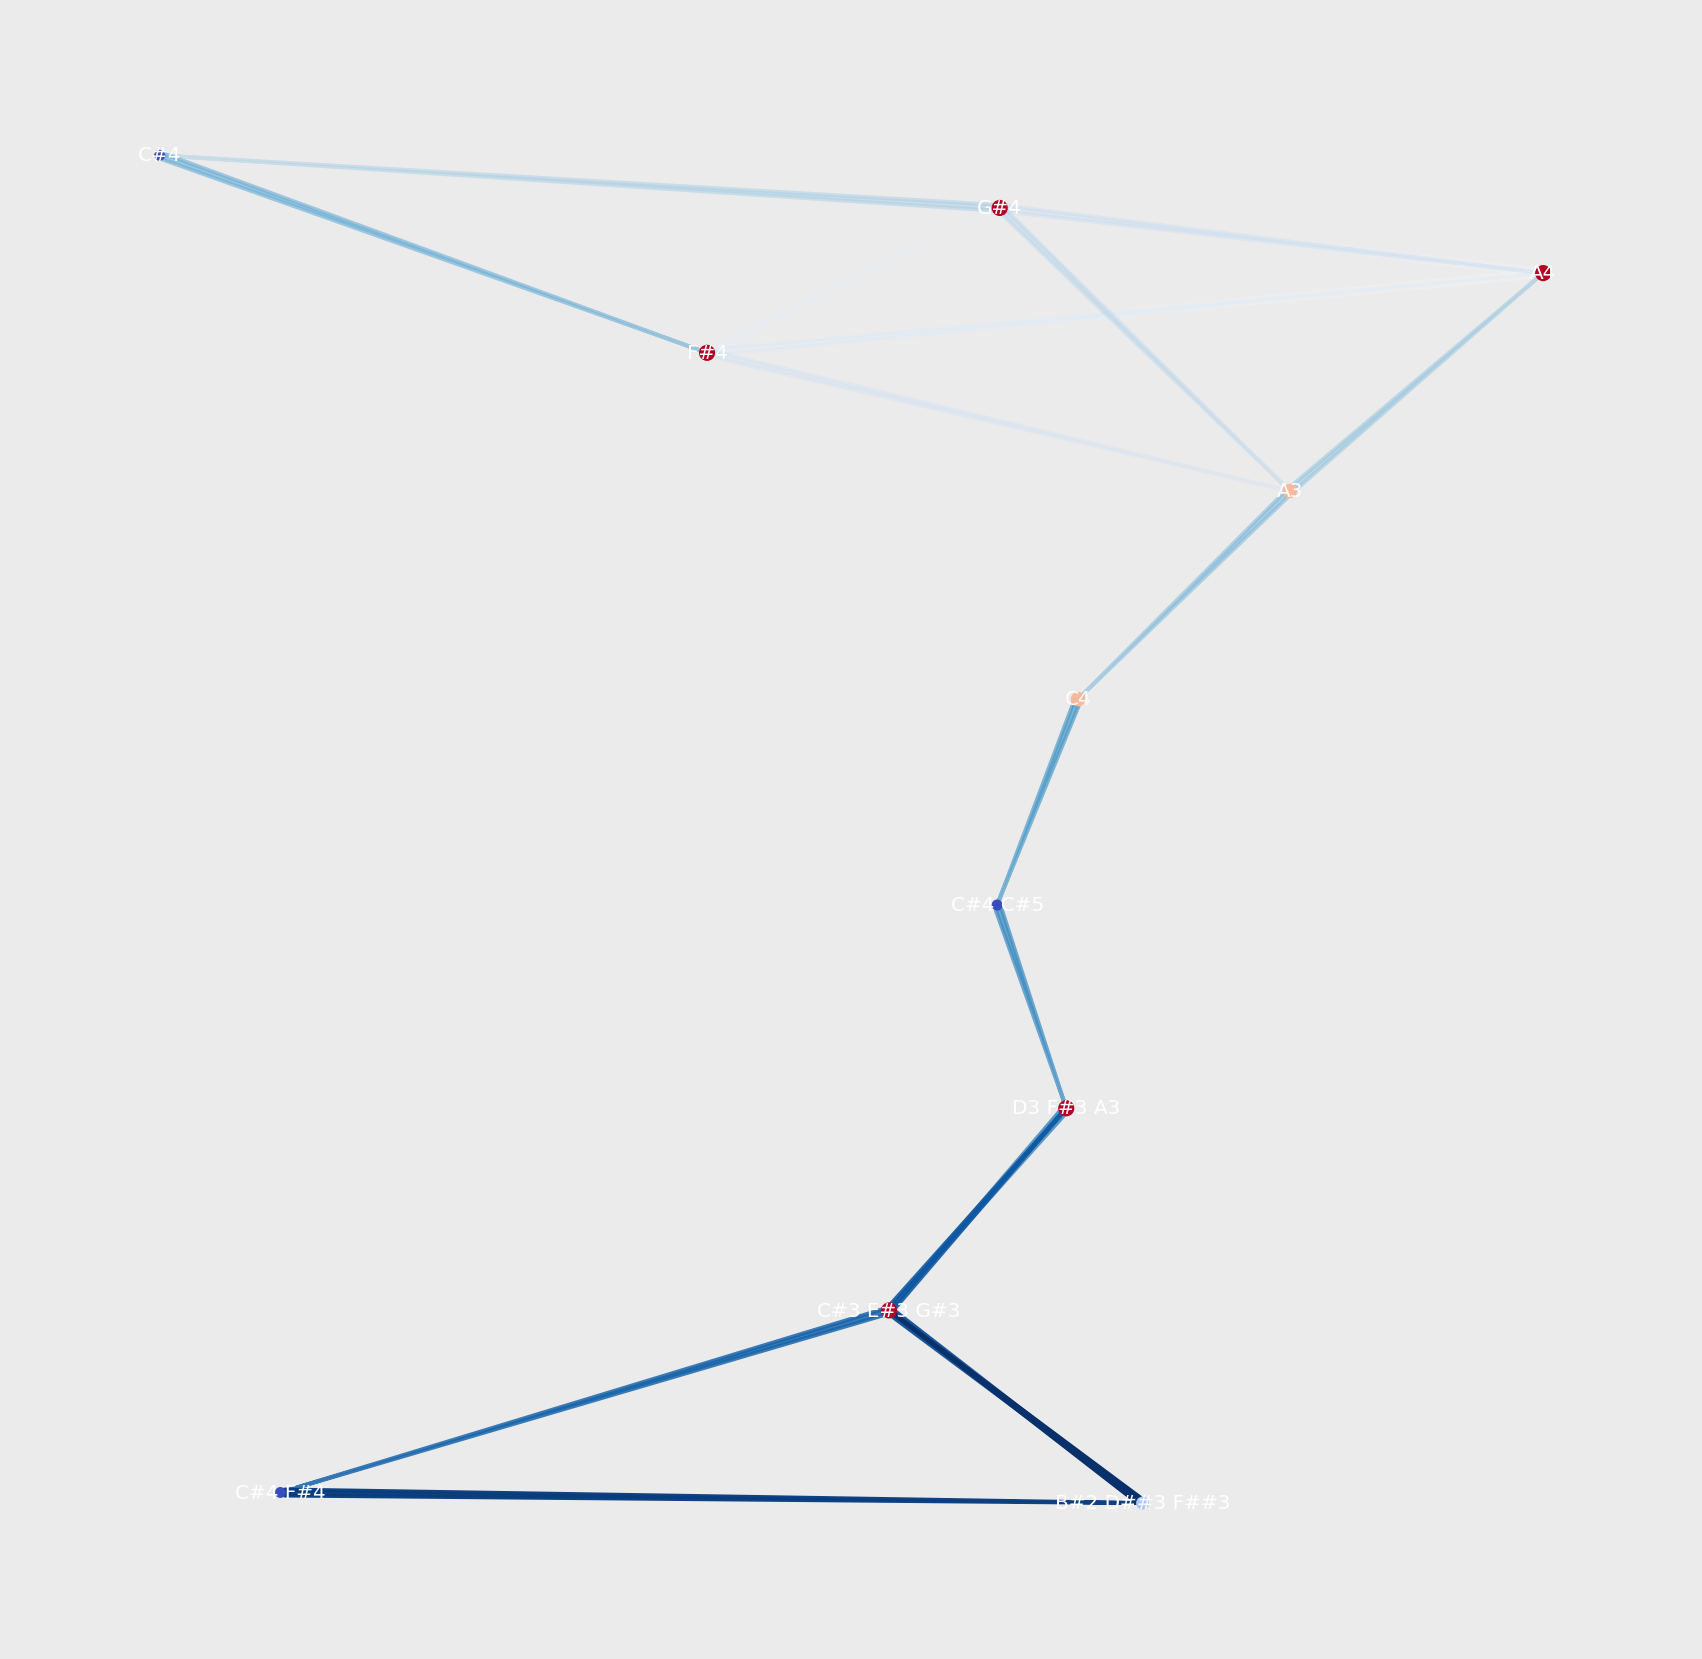

Pasando grafo a formato tridimensional...
Listo.


In [171]:
#Esta celda es para comparar dos canciones y ver si hay algún tipo de plagio
import igraph as ig
import netgraph, numpy, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import music21 as m
from os import listdir
from os.path import isfile, join
import chart_studio.plotly as py
import plotly.graph_objs as go
from collections import Counter

def song_to_dict():
    aDir = os.getcwd()

    onlyfiles = [f for f in listdir('{0}/ArchiXml/'.format(aDir)) if isfile(join('{0}/ArchiXml/'.format(aDir), f))]
    #Imprimir archivos disponibles
    for i in onlyfiles:
        print(i.replace('.xml',''))

    nombre = input("Escriba el nombre del archivo:\n")
    song = m.converter.parse('{0}/ArchiXml/{1}.xml'.format(aDir, nombre))
    print("Separando archivo por partes...")
    partes = []
    compaces = []
    notas = []
    acordes = []
    # print(partes["piano"])
    # print(partes["piano"]["compas 1"])
    # print(partes["piano"]["compas 1"]["notas"])
    # print(partes["piano"]["compas 1"]["notas"][0])
    # print(partes["piano"]["compas 1"]["acordes"])
    # print(partes["piano"]["compas 1"]["acordes"][0])
    for i in song.parts:
        parte = ""
        if i.partName == None:
            parte = "piano"
        else:
            parte = str(i.partName)
        partes.append(parte)
        print(parte)
        temCompaces = []
        for j in i.recurse().getElementsByClass('Measure'):
            numer = int(j.number)
            compa = "M{0}".format(numer)
            temNotas = []
            temAcordes = []
            for k in j.recurse().getElementsByClass('Note'):
                temNotas.append(str(k.nameWithOctave.replace("-","b")))
            for k in j.recurse().getElementsByClass('Chord'):
                n = ''
                for l in k.notes:
                    n += ' '+l.nameWithOctave.replace("-","b")
                temAcordes.append(n[1:])
            if(temNotas != [] or temAcordes != []):
                temCompaces.append({compa : {"notas" : temNotas, "acordes" : temAcordes}})
            notas += temNotas
            acordes += temAcordes
        compaces.append(temCompaces)

    c = 1
    print("Agrupando los compaces...")
    Compaces = []
    for i in compaces:
        if i != []:
            xx = i[0]
            for f in range(len(i)-1):
                yy = i[f+1]
                xx.update(yy)
            Compaces.append(xx)

    cancion = {}
    o = len(Compaces)
    for i in range(o-1):
        partes[i] = (c-1)
        partes[i+1] = c
        c+=1
    
    for i in range(o):
        cancion.update({partes[i] : Compaces[i]})
#     print("Compaces, notas y acordes de {0}:\n{1}".format(nombre,cancion))
#     print("Notas de {0}:\n{1}".format(nombre,notas))
#     print("Acordes de {0}:\n{1}".format(nombre,acordes))
    print("Listo.")
    return cancion,notas,acordes,nombre

def m_graph(n,nombre):
    print("Convirtiendo grafo a formato 2-dimensional...")
    aDir = os.getcwd()
    G = nx.DiGraph()
    for i in range(len(n)):
        if i != 0:
            G.add_edge(n[i-1], n[i])

    pos = nx.layout.kamada_kawai_layout(G)

    d = dict(G.degree)
    low, *_, high = sorted(d.values())
    norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm)
    node_sizes = [v*10 for v in d.values()]
    M = G.number_of_edges()
    edge_colors = range(2, M+2)
    edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
    fig = plt.figure()
    nodes = nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_sizes,
        node_color=[mapper.to_rgba(i) for i in d.values()]
    )
    edges = nx.draw_networkx_edges(
        G,
        pos,
        node_size=node_sizes,
        arrowstyle="wedge",
        arrowsize=10,
        edge_color=edge_colors,
        edge_cmap=plt.cm.Blues,
        width=2,
    )
    labels = nx.draw_networkx_labels(
        G,
        pos,
        font_size=10,
        font_color="white",
    )
    # set alpha value for each edge
    colorFE = []
    for i in range(M):
        edges[i].set_alpha(edge_alphas[i])
        colorFE.append(edge_alphas[i])

    # pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
    # pc.set_array(edge_colors)
    # plt.colorbar(pc)

    ax = plt.gca()
    ax.set_axis_off()
    fig.set_facecolor("#9e999830")
    fig.set_size_inches((15, 15))
    plt.savefig('{0}/GrafosImgs/Grafo_{1}.png'.format(aDir,nombre))
    print("Listo.")
    plt.show()
    return G,nombre
    
g = song_to_dict()

g2D = m_graph(g[1]+g[2],g[3])

c_3D(g2D[0],g2D[1])